# Conditional gan

In [1]:
import os
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense,Reshape, Conv2D
from tensorflow.keras.layers import BatchNormalization,Activation
from tensorflow.keras.layers import Conv2DTranspose,Flatten, LeakyReLU, concatenate
from tensorflow.keras.datasets import mnist
from PIL import Image
from matplotlib.pyplot import imshow

In [2]:
from tensorflow.keras.datasets import mnist
(xtr,ytr),_ = mnist.load_data()
xtr = xtr.reshape((-1,28,28,1)).astype('float32')/255
ytr = to_categorical(ytr)

### Create a dataViewer

In [3]:
%matplotlib inline
from GAN.utils import dataViewer

In [4]:
def viewMnist(mtr):
    '''Return from a numpy array an Image'''
    mtr = mtr.reshape((28,28))
    mtr *= 255
    mtr = np.clip(mtr,0,255).astype('uint8')
    imshow(mtr,cmap='gray')
def saveMnist(mtr,path):
    '''Save as file the numpy array'''
    mtr = mtr.reshape((28,28))
    mtr *= 255
    mtr = np.clip(mtr,0,255).astype('uint8')
    Image.fromarray(mtr).resize((280,280)).save(path)

In [5]:
vwr = dataViewer(functionView=viewMnist,functionSave=saveMnist,path="D:/Project/DeepLearning/GAN/cGAN/output/")

### Create a cGAN instance

In [6]:
#Generator

def buildGen():

    kernel_size = 5
    layer_filters = [128, 64, 32, 1]

    inpt = Input(shape=(100,),name='LatentInp')
    lbl = Input(shape=(10,),name='LabelInp')

    kernel_size = 5
    layer_filters = [128, 64, 32, 1]

    x = concatenate([inpt, lbl], axis=1)
    x = Dense(7 * 7 * layer_filters[0])(x)
    x = Reshape((7, 7, layer_filters[0]))(x)

    for filters in layer_filters:
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters,kernel_size=kernel_size,strides=strides,padding='same')(x)

    x = Activation('sigmoid')(x)

    return Model([inpt,lbl], x, name='generator')

generator = buildGen()
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
LatentInp (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________________
LabelInp (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 110)          0           LatentInp[0][0]                  
                                                                 LabelInp[0][0]                   
__________________________________________________________________________________________________
dense (Dense)                   (None, 6272)         696192      concatenate[0][0]        

In [7]:
#Discriminator

def buidDis():
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]

    inp = Input(shape=(28,28,1),name='LatentInp')
    lbl = Input(shape=(10,),name='LabelInp')

    y = Dense(28 * 28)(lbl)
    y = Reshape((28, 28, 1))(y)
    x = concatenate([inp, y])

    for filters in layer_filters:
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(x)

    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)

    return Model([inp, lbl], x, name='discriminator')

discriminator = buidDis()
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
LabelInp (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 784)          8624        LabelInp[0][0]                   
__________________________________________________________________________________________________
LatentInp (InputLayer)          [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 28, 28, 1)    0           dense_1[0][0]                    
______________________________________________________________________________________

In [8]:
from GAN.GAN.LabelGAN import cGAN

In [9]:
gan = cGAN(generator=generator,discriminator=discriminator,DiscrOptimizer=RMSprop(lr=2e-4, decay=6e-8),GanOptimizer=RMSprop(lr=1e-4, decay=3e-8))

In [10]:
gan.generateBatchEval(16)

### Train the cGAN

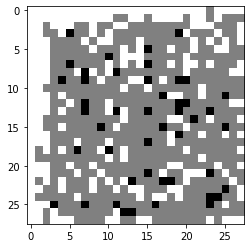

In [11]:
gan.GenerateOutputs(xtest=gan.evaluationInpt,batchSize=16,returnArray=False,dataViewer=vwr,save=True,View=False,epoch=0)
gan.GenerateOutputs(batchSize=1,returnArray=False,dataViewer=vwr,save=False,View=True,epoch=0)

In [14]:
gan.train(x_train=[xtr,ytr],batch_size=1024,epoch=30,evalStep=(1,10),dataViewer=vwr,pathSave='D:/Project/DeepLearning/GAN/cGAN/save')

Epoch 1
117/117 [==============================] - 97s 830ms/step
Discrimiator: (loss,acc)=(1.343920757790329e-05,1.0)
 	 Adversial: (loss,acc)=(6.746642611688003e-06,1.0)
Epoch 2
117/117 [==============================] - 98s 841ms/step
Discrimiator: (loss,acc)=(1.8474780321121216,0.5)
 	 Adversial: (loss,acc)=(7.638718605041504,0.0)
Epoch 3
117/117 [==============================] - 102s 873ms/step
Discrimiator: (loss,acc)=(0.6699057221412659,0.51171875)
 	 Adversial: (loss,acc)=(11.756094932556152,0.0)
Epoch 4
117/117 [==============================] - 104s 886ms/step
Discrimiator: (loss,acc)=(0.09763706475496292,0.998046875)
 	 Adversial: (loss,acc)=(2.691343069076538,0.0)
Epoch 5
117/117 [==============================] - 105s 895ms/step
Discrimiator: (loss,acc)=(0.012591889128088951,0.99609375)
 	 Adversial: (loss,acc)=(0.005166263785213232,1.0)
Epoch 6
117/117 [==============================] - 107s 911ms/step
Discrimiator: (loss,acc)=(0.29379022121429443,0.8583984375)
 	 Advers